In [134]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [156]:
# read in image
img = mpimg.imread('./Dataset-3/Day-Time/inputs/Lane_Input_7.png')# solidWhiteRight.jpg') #./Dataset-3/Modified Carla/inputs/Town04_Clear_Noon_09_09_2020_14_57_22_frame_503.png')
# grab dimensions & make copy
ysize,xsize = img.shape[0], img.shape[1]
img_copy = np.copy(img)

In [157]:
# identify potential lanes within the image
r_thres, g_thres, b_thres = 200,200,200
rgb_thres = [r_thres,g_thres,b_thres]

thresholds = (img[:,:,0] < rgb_thres[0]) | (img[:,:,1] < rgb_thres[1]) | (img[:,:,2] < rgb_thres[2])
img_copy[thresholds] = [0,0,0]

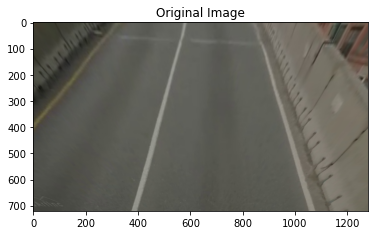

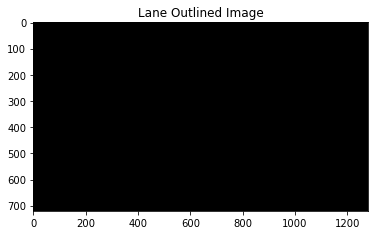

In [158]:
# display image
plt.imshow(img)
plt.title('Original Image')
plt.show()
plt.imshow(img_copy)
plt.title('Lane Outlined Image')
plt.show()

## Color Selection (Testing with basic image with clearly defined solid whites)

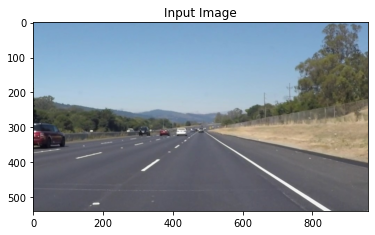

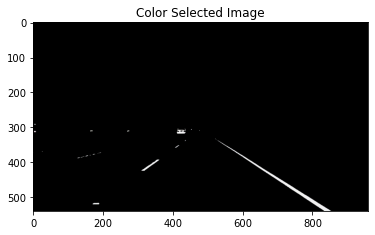

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image
img = mpimg.imread('./basic_tests/solidWhiteRight.jpg')

# Grab the x and y size and make a copy of the image
ysize, xsize = img.shape[0], img.shape[1]
img_copy = np.copy(img)

# color selection criteria
r_thres, g_thres, b_thres = 210,210,210
#rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Do a boolean or with the "|" character to identify
# pixels below the thresholds
rgb_thres = (img[:,:,0] < r_thres) \
            | (img[:,:,1] < g_thres) \
            | (img[:,:,2] < b_thres)
img_copy[rgb_thres] = [0,0,0]

# Display the image
plt.imshow(img)
plt.title("Input Image")
plt.show()
plt.imshow(img_copy)
plt.title("Color Selected Image")
plt.show()

## Region Masking

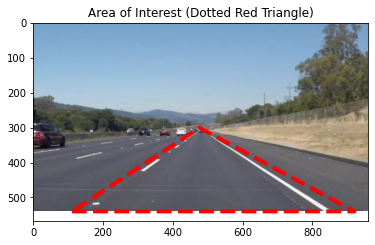

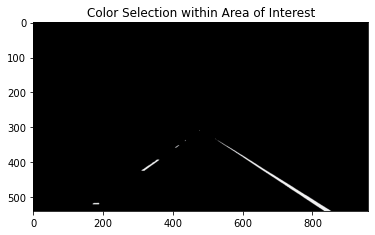

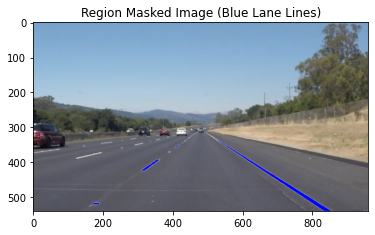

In [40]:
# Read in the image
img = mpimg.imread('./basic_tests/solidWhiteRight.jpg')

# grab dimensions & make copy
ysize, xsize = img.shape[0], img.shape[1]
img_copy = np.copy(img)
img_copy2 = np.copy(img)

# color selection criteria
r_thres, g_thres, b_thres = 210,210,210

# rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define mask region (triangle)
left_bottom = [110, 540]
right_bottom = [920, 540]
top = [475, 300]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
l_fit = np.polyfit((left_bottom[0], top[0]), (left_bottom[1], top[1]), 1)
r_fit = np.polyfit((right_bottom[0], top[0]), (right_bottom[1], top[1]), 1)
b_fit = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (img[:,:,0] < r_thres) | \
                    (img[:,:,1] < g_thres) | \
                    (img[:,:,2] < b_thres)

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*l_fit[0] + l_fit[1])) & \
                    (YY > (XX*r_fit[0] + r_fit[1])) & \
                    (YY < (XX*b_fit[0] + b_fit[1]))
                    
# Mask color and region selection
img_copy[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
img_copy2[~color_thresholds & region_thresholds] = [0, 0, 255]

# Display the image and show region and color selections
plt.imshow(img)
x = [left_bottom[0], right_bottom[0], top[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], top[1], left_bottom[1]]
plt.plot(x, y, 'r--', lw=4)
plt.title("Area of Interest (Dotted Red Triangle)")
plt.show()
plt.imshow(img_copy)
plt.title("Color Selection within Area of Interest")
plt.show()
plt.imshow(img_copy2)
plt.title("Region Masked Image (Blue Lane Lines)")
plt.show()

## Adding Canny Edge to Better Detect Yellow Lanes and other Obscure Colors

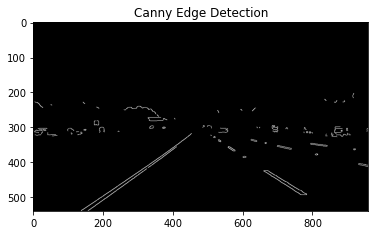

In [37]:
# Do all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read image & convert to grayscale
img = mpimg.imread('./basic_tests/solidYellowLeft.jpg')
gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

# kernel size = 5
gray_blurring = cv2.GaussianBlur(gray_img,(5, 5),0)

# Define our parameters for Canny and run it
#low_threshold = 180
#high_threshold = 240
edges = cv2.Canny(gray_blurring, 180, 240)

# Display the image
plt.imshow(edges, cmap='Greys_r')
plt.title("Canny Edge Detection")
plt.show()

## Hough Transform

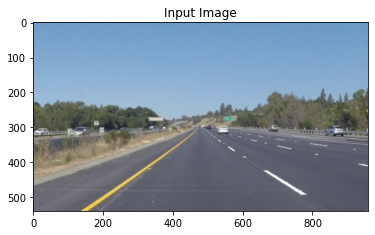

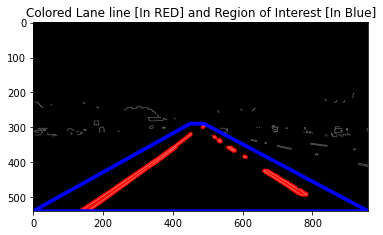

In [36]:
# Read image & convert to grayscale
img = mpimg.imread('./basic_tests/solidYellowLeft.jpg')
gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

# kernel_size = 5
gray_blurring = cv2.GaussianBlur(gray_img,(5, 5),0)

# Define our parameters for Canny and apply
#low_threshold = 180
#high_threshold = 240
edges = cv2.Canny(gray_blurring, 180, 240)

#create masked edge image
mask = np.zeros_like(edges)
ignore_mask_color = 255

# This time we are defining a four sided polygon to mask
imshape = img.shape
vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, 255)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 2     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 4 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments
line_image = np.copy(img)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
lines_edges = cv2.polylines(lines_edges,vertices, True, (0,0,255), 10)
plt.imshow(img)
plt.title("Input Image")
plt.show()
plt.imshow(lines_edges)
plt.title("Colored Lane line [In RED] and Region of Interest [In Blue]")
plt.show()

In [29]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def slope_lines(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #print(left_line, right_line)

    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)

        #we know that equation of line is y=mx +c so we can write it x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)
    
    #cv2.polylines(img,np.array([poly_vertices],'int32'), True, (0,0,255), 10)
    #print(poly_vertices)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    line_img = slope_lines(line_img,lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    #lines_edges = cv2.polylines(lines_edges,get_vertices(img), True, (0,0,255), 10)
    return lines_edges
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [30]:
# Lane finding Pipeline
def lane_finding_pipeline(image):
    
    #Grayscale
    gray_img = grayscale(image)
    #Gaussian Smoothing
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    #Canny Edge Detection
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #Masked Image Within a Polygon
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    #Hough Transform Lines
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #Draw lines on edges
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    
    return output

In [32]:
import os

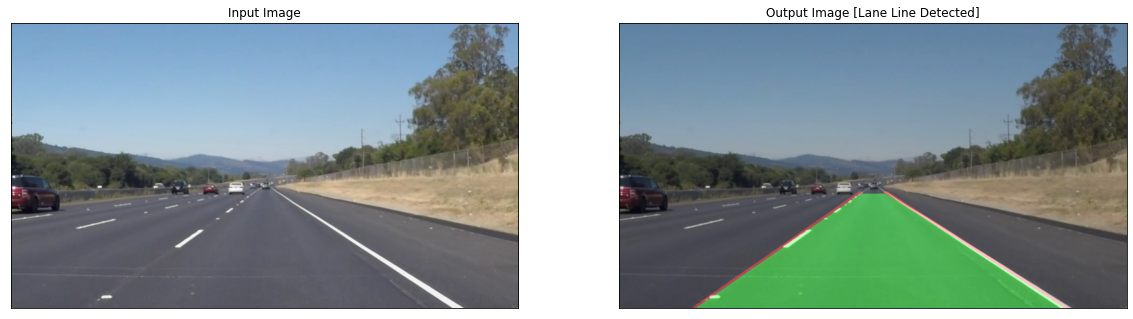

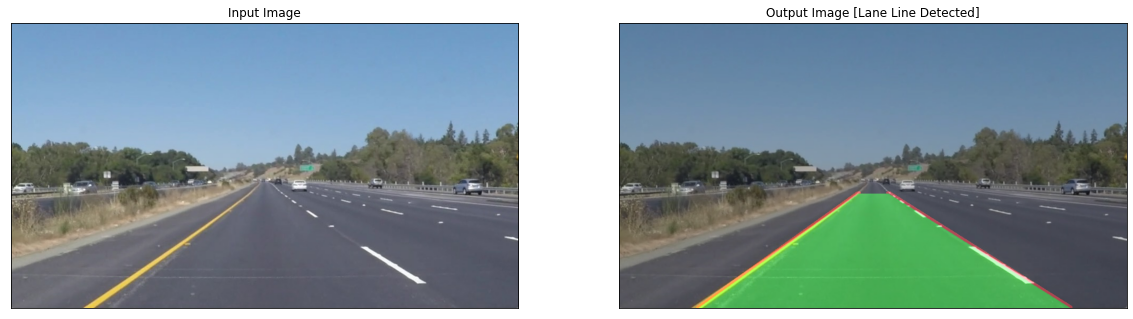

In [35]:
for image_path in list(os.listdir('./basic_tests')): # add test images
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./basic_tests/{image_path}')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input Image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(lane_finding_pipeline(image))
    ax.set_title("Output Image [Lane Line Detected]")
    plt.show()